In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
import numpy as np
import matplotlib.pyplot as plt
from src.ortools_solver import CVRP_solver
from src.utils import random_task_generation
from src.pipette_scheduler import calculate_D, calculate_S_E, calculate_D_prime,calculate_T
from src.baseline_methods import LAP, greedy
import pandas as pd

/Users/roywu/Desktop/MIT/Project/pipette_scheduling


In [4]:
labware_list =[12,24,96,384]
# enumerate all the two combinations of the labware_list
labware_combinations = []
for i in range(len(labware_list)):
    for j in range(len(labware_list)):
        labware_combinations.append([labware_list[i], labware_list[j]])
#labware_combinations.append([1536,1536])
#labware_combinations

In [3]:
# establish an empty dataframe to store the results
df = pd.DataFrame(columns=['source_labware', 'dest_labware', 'num_samples', 'repeat', 'unoptimized','rowwise', 'greedy','VRP'])

In [4]:
np.random.seed(0)
for labware_combination in labware_combinations: 

    source_dim = labware_combination[0]
    dest_dim = labware_combination[1]
    print(f'source_dim={source_dim}, dest_dim={dest_dim}')
    for r in range(3):
        print('repeat:',r+1)
        stats = []
        for i in range(1, 11, 1):

            num_candidates = dest_dim * i 
            num_candidates = int(num_candidates)
            print(f'num_candidates={num_candidates}')
            a = random_task_generation(source_dim,dest_dim,num_candidates)
            #a[a>0] = 1
            jobs = np.argwhere(a)
            D_S = calculate_D(a.shape[0])
            D_D = calculate_D(a.shape[1])
            S, E, volumes = calculate_S_E(a)
            # calculate distance matrix
            D_prime = calculate_D_prime(D_S, D_D, S, E, volumes, 1, 100, 1, 100)
            # VRP solver
            VRP_distance, VRP_recorder = CVRP_solver(np.round(D_prime * 100).astype(np.int64), solving_time=20)
            VRP_distance = VRP_distance / 100
            print(f'VRP_distance: {VRP_distance}')
            # calculate the cost of the non-optimized sequence
            tasks = np.array(range(jobs.shape[0]))
            tasks = tasks+1
            # if tasks.shape[0] %8 != 0, pad with -1
            if tasks.shape[0] %8 != 0:
                tasks = np.pad(tasks, (0, 8-tasks.shape[0]%8), 'constant', constant_values=-1)
            unoptimized_seuqnece = tasks.reshape(-1, 8)
            t = calculate_T(unoptimized_seuqnece)
            d = np.round(D_prime * 100)
            non_optimized_distance = np.trace(np.dot(t.T, d))/100
            # change non_optimized_distance to integer
            non_optimized_distance = int(non_optimized_distance)
            print(f'non_optimized_distance: {non_optimized_distance}')
            
            # calculate the cost of the row-wise optimized sequence
            index_matrix = np.zeros((source_dim,dest_dim))
            for j in range(jobs.shape[0]):
                index_matrix[jobs[j, 0], jobs[j, 1]] = j+1
            row_wise_optimized_sequence = LAP(index_matrix)
            if row_wise_optimized_sequence.shape[0] %8 != 0:
                row_wise_optimized_sequence = np.pad(row_wise_optimized_sequence, (0, 8-row_wise_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
            row_wise_optimized_sequence = row_wise_optimized_sequence.reshape(-1, 8)
            t = calculate_T(row_wise_optimized_sequence)
            row_wise_optimized_distance = np.trace(np.dot(t.T, d))/100
            # change non_optimized_distance to integer
            row_wise_optimized_distance = int(row_wise_optimized_distance)
            print(f'row_wise_optimized_distance: {row_wise_optimized_distance}')

            # calculate the cost of the greedy optimized sequence
            greedy_optimized_sequence = greedy(jobs, d[1:,1:])
            if greedy_optimized_sequence.shape[0] %8 != 0:
                greedy_optimized_sequence = np.pad(greedy_optimized_sequence, (0, 8-greedy_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
            greedy_optimized_sequence = greedy_optimized_sequence.reshape(-1, 8)
            t = calculate_T(greedy_optimized_sequence)
            greedy_optimized_distance = np.trace(np.dot(t.T, d))/100
            print(f'greedy_optimized_distance: {greedy_optimized_distance}')
            # append the results to the df
            stats.append([source_dim, dest_dim, num_candidates, r+1, non_optimized_distance, row_wise_optimized_distance, greedy_optimized_distance, VRP_distance])
        # convert the stats to the dataframe
        stats = pd.DataFrame(stats, columns=['source_labware', 'dest_labware', 'num_samples', 'repeat', 'unoptimized','rowwise', 'greedy','VRP'])
        # append the stats to the df
        df = pd.concat([df, stats], ignore_index=True)
        print(df)


source_dim=12, dest_dim=12
repeat: 1
num_candidates=12
VRP_distance: 25.77
non_optimized_distance: 30
row_wise_optimized_distance: 28
greedy_optimized_distance: 32.85
num_candidates=24
VRP_distance: 43.84
non_optimized_distance: 58
row_wise_optimized_distance: 53
greedy_optimized_distance: 61.86
num_candidates=36
VRP_distance: 69.3
non_optimized_distance: 94
row_wise_optimized_distance: 87
greedy_optimized_distance: 94.79
num_candidates=48
VRP_distance: 77.28
non_optimized_distance: 125
row_wise_optimized_distance: 99
greedy_optimized_distance: 130.34
num_candidates=60
VRP_distance: 96.21
non_optimized_distance: 146
row_wise_optimized_distance: 129
greedy_optimized_distance: 166.11
num_candidates=72
VRP_distance: 111.71
non_optimized_distance: 176
row_wise_optimized_distance: 155
greedy_optimized_distance: 192.38
num_candidates=84
VRP_distance: 128.94
non_optimized_distance: 201
row_wise_optimized_distance: 186
greedy_optimized_distance: 222.6
num_candidates=96
VRP_distance: 138.63
non

/var/folders/rt/qt1716456c913tnjd66ntj8w0000gn/T/ipykernel_34691/2897386322.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, stats], ignore_index=True)


VRP_distance: 23.87
non_optimized_distance: 26
row_wise_optimized_distance: 25
greedy_optimized_distance: 28.32
num_candidates=24
VRP_distance: 52.74
non_optimized_distance: 59
row_wise_optimized_distance: 60
greedy_optimized_distance: 64.1
num_candidates=36
VRP_distance: 68.77
non_optimized_distance: 96
row_wise_optimized_distance: 86
greedy_optimized_distance: 105.2
num_candidates=48
VRP_distance: 83.33
non_optimized_distance: 127
row_wise_optimized_distance: 106
greedy_optimized_distance: 138.17
num_candidates=60
VRP_distance: 95.5
non_optimized_distance: 147
row_wise_optimized_distance: 127
greedy_optimized_distance: 155.23
num_candidates=72
VRP_distance: 112.84
non_optimized_distance: 177
row_wise_optimized_distance: 150
greedy_optimized_distance: 192.57
num_candidates=84
VRP_distance: 124.33
non_optimized_distance: 210
row_wise_optimized_distance: 166
greedy_optimized_distance: 223.26
num_candidates=96
VRP_distance: 140.51
non_optimized_distance: 235
row_wise_optimized_distance: 

In [5]:
df.to_csv('/Users/roywu/Desktop/MIT/Project/pipette_scheduling/results/results_different_labwares_new_method.csv', index=False)

In [2]:
# read the csv file
df = pd.read_csv('/Users/roywu/Desktop/MIT/Project/pipette_scheduling/results/results_different_labwares_new_method.csv')

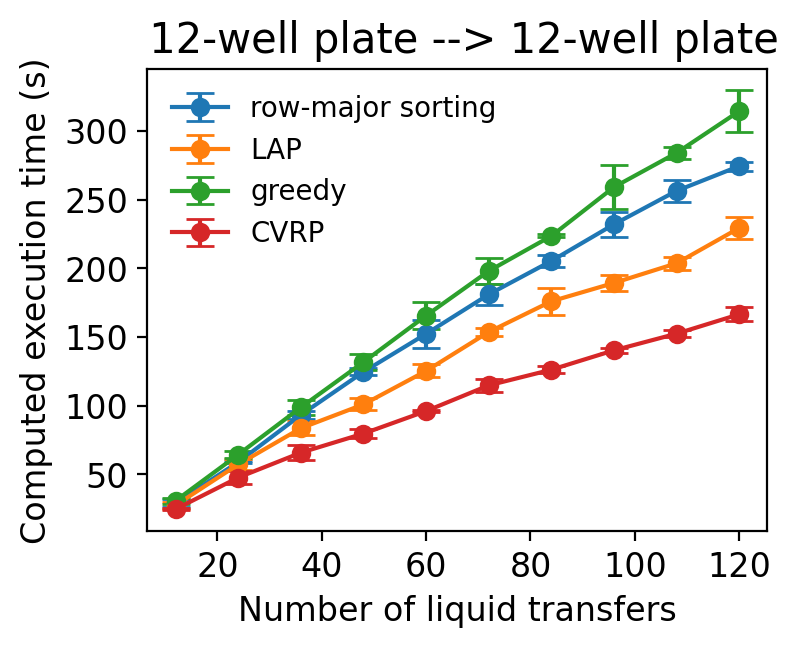

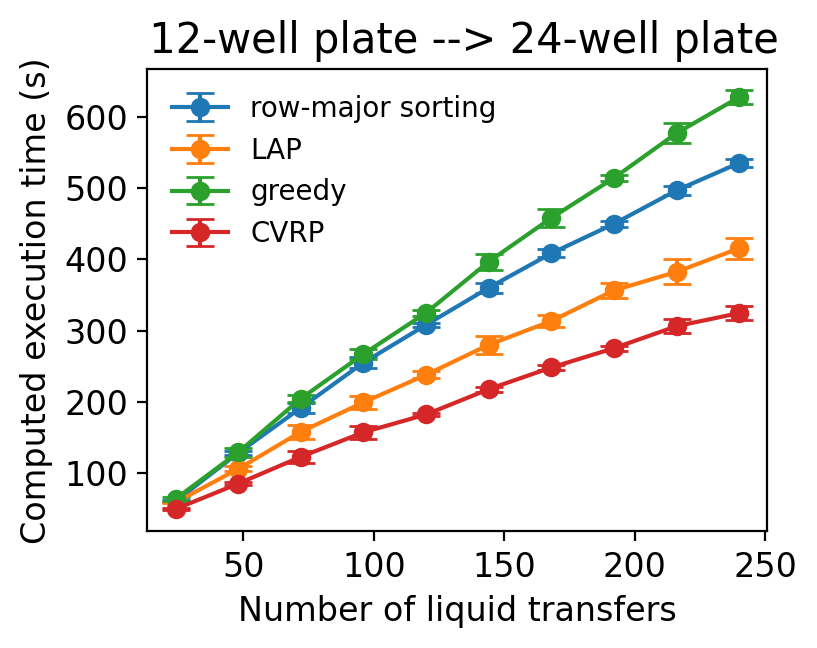

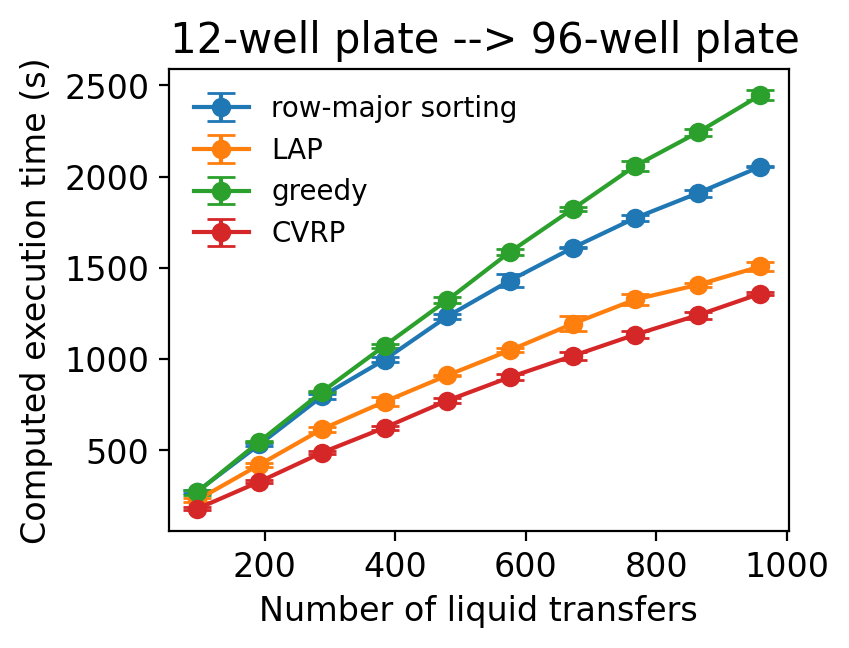

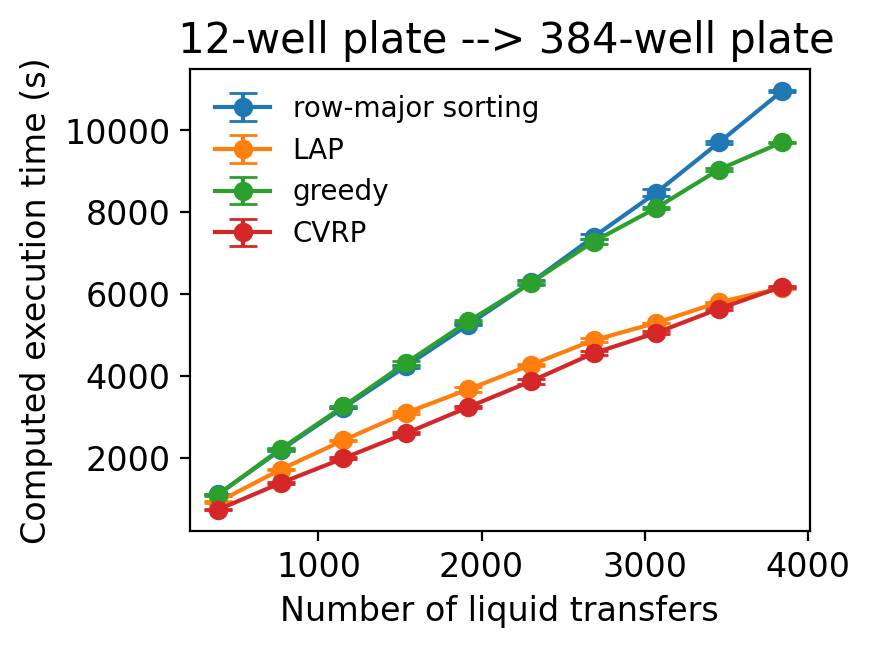

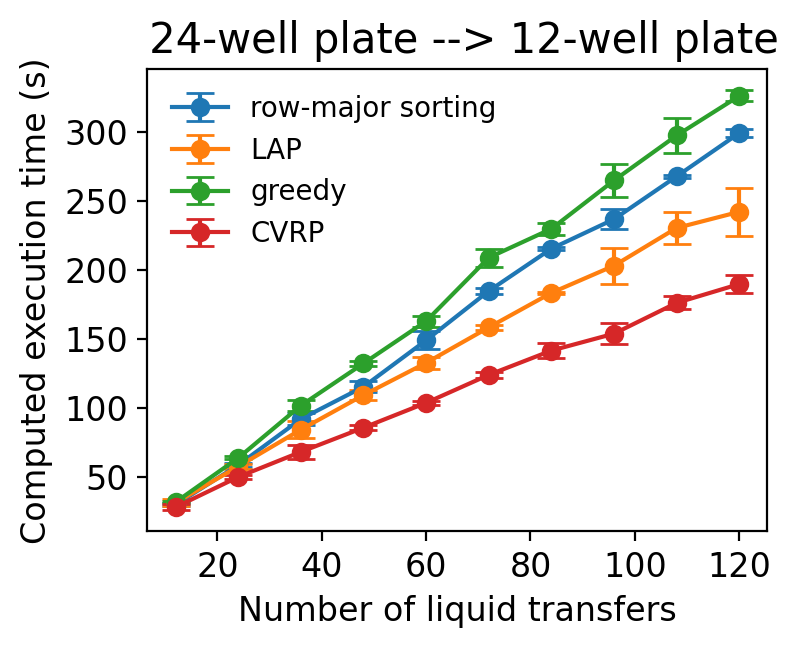

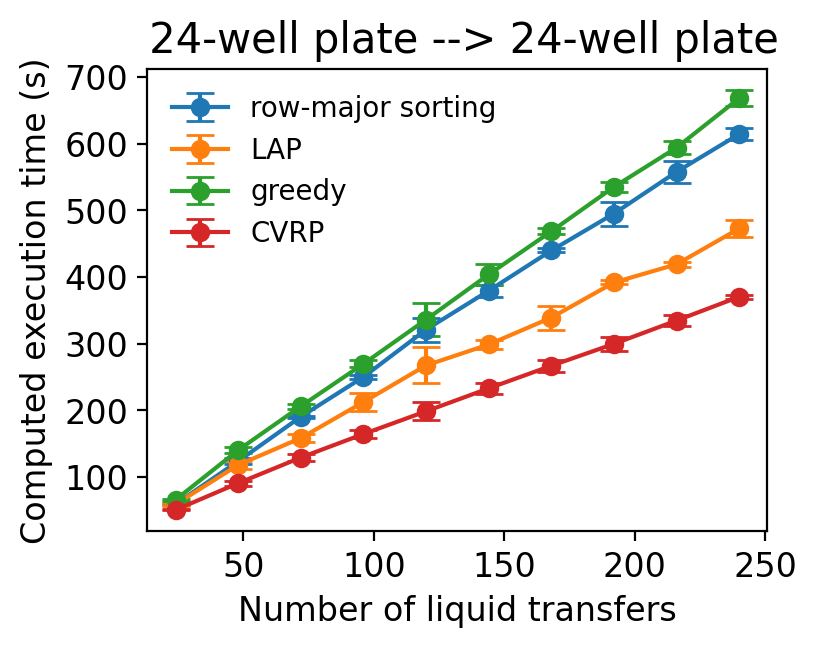

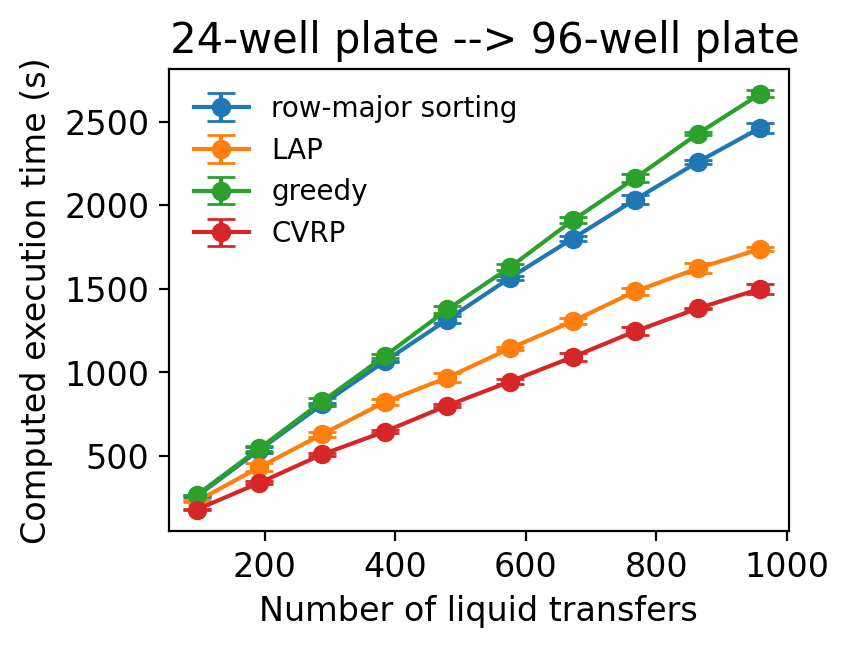

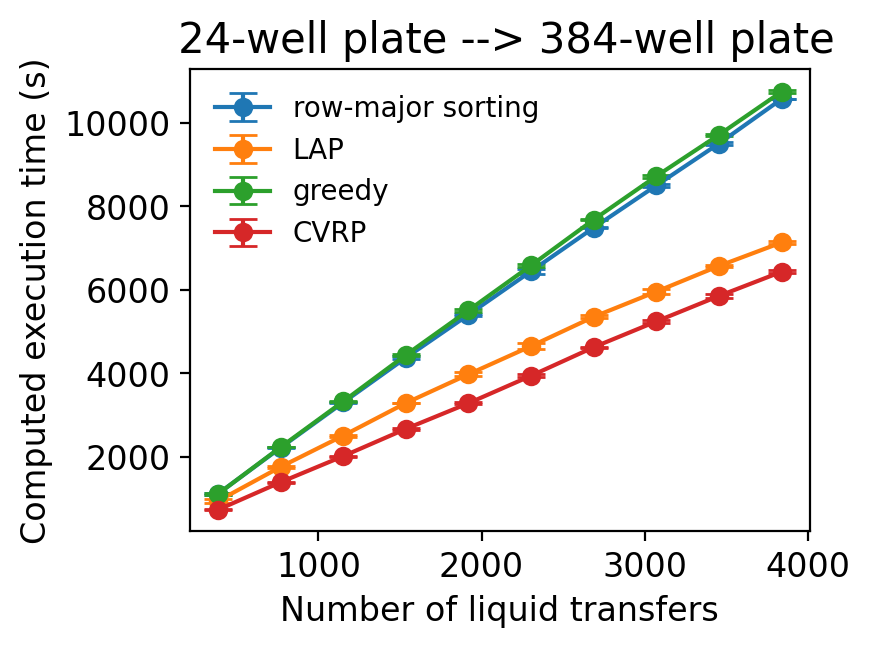

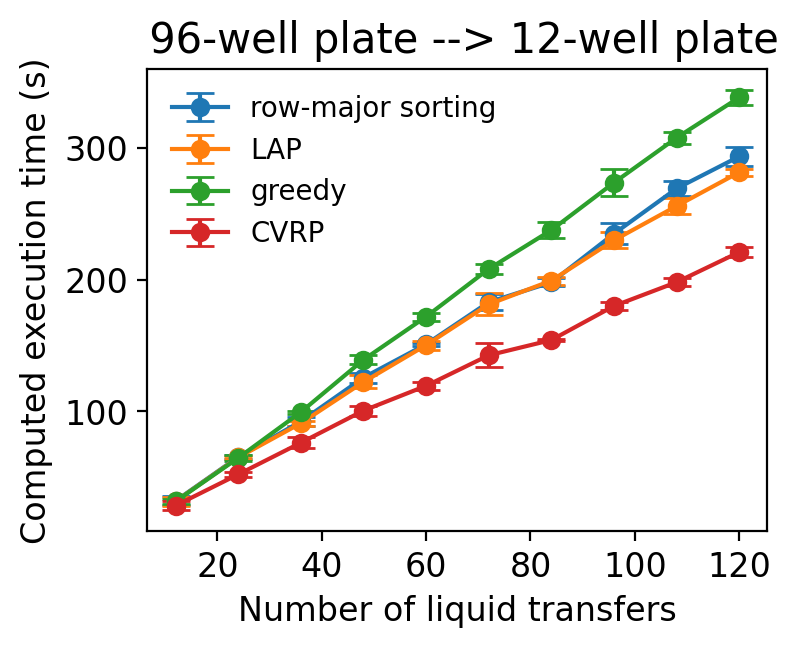

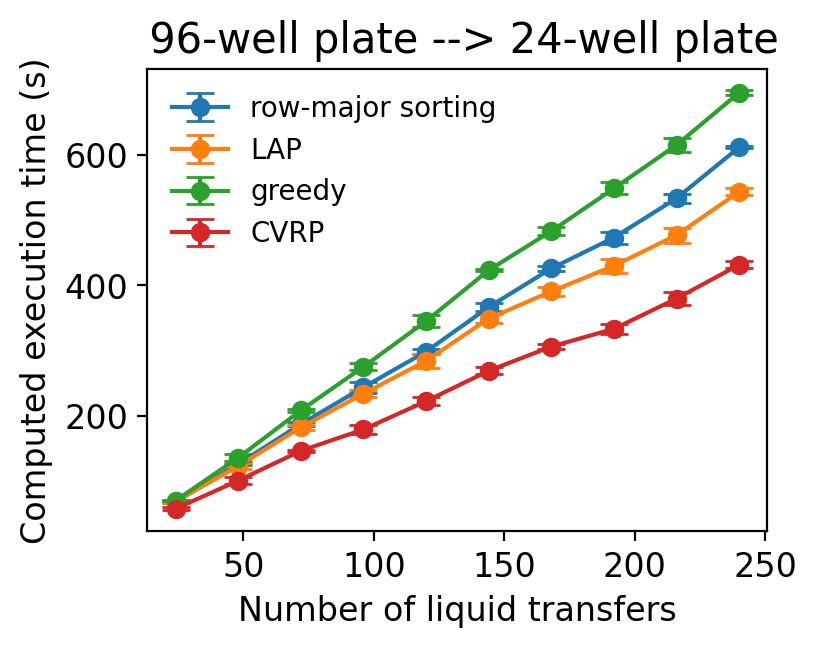

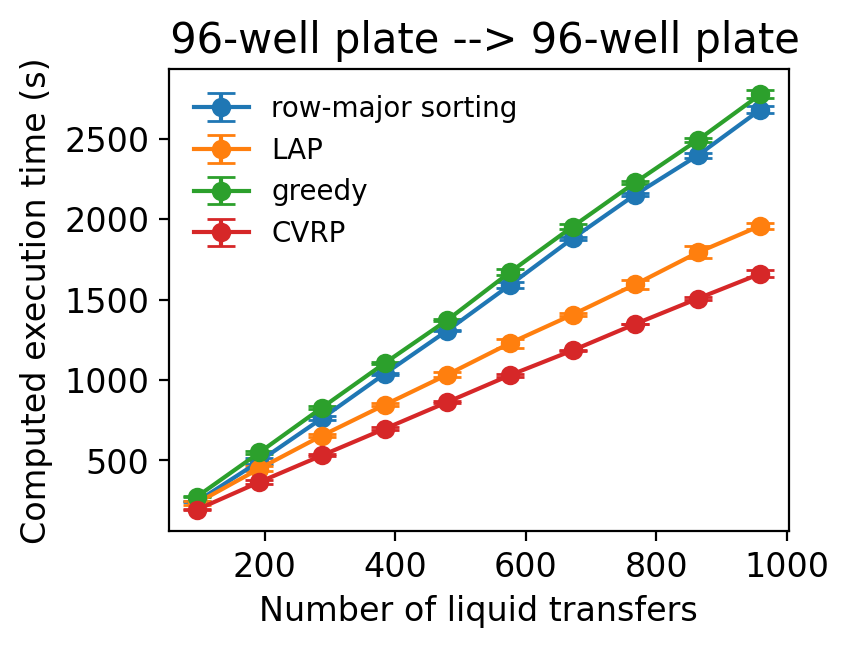

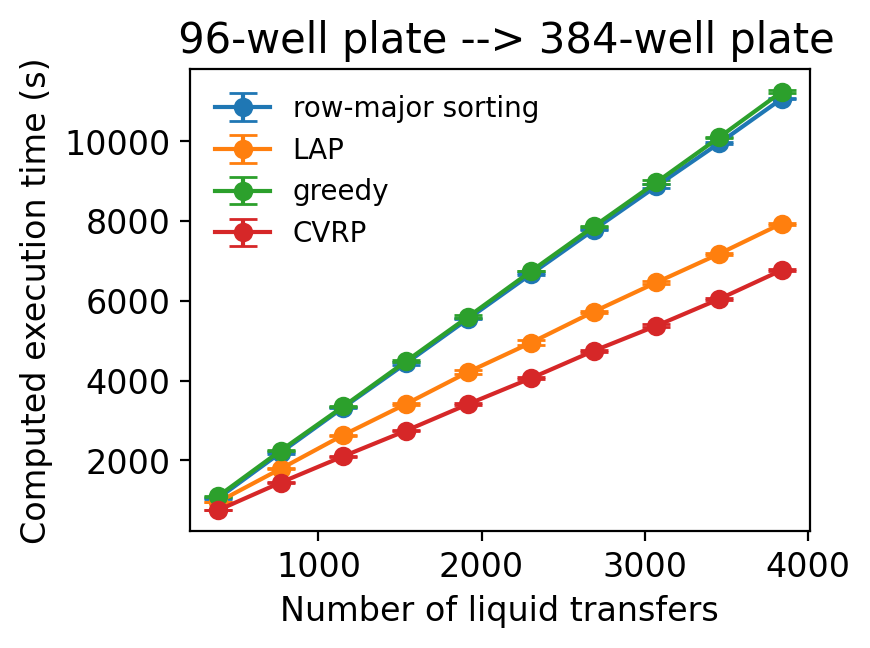

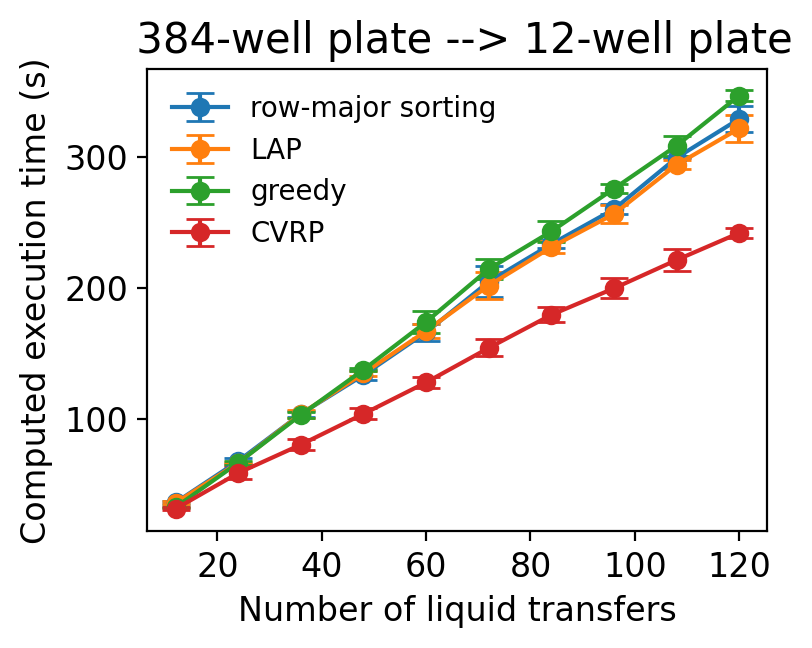

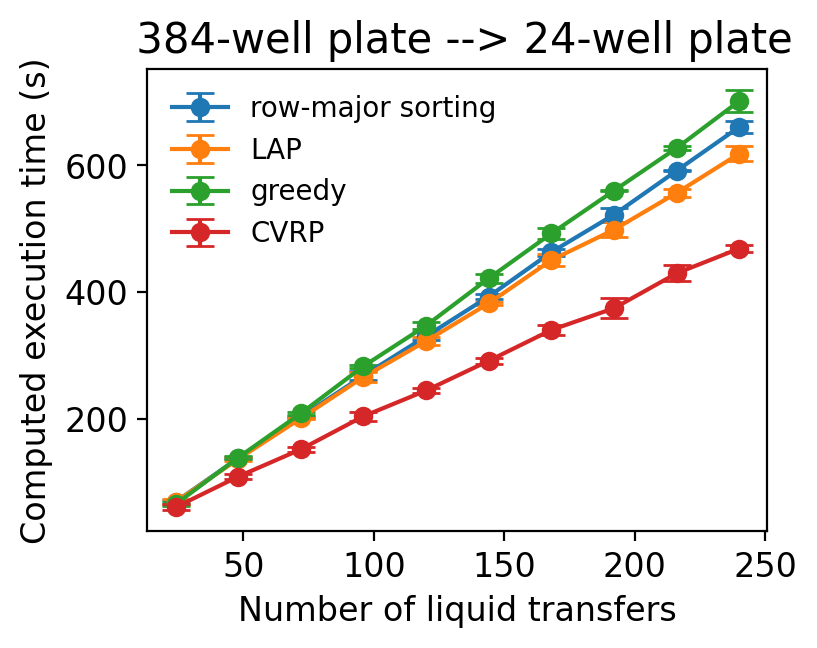

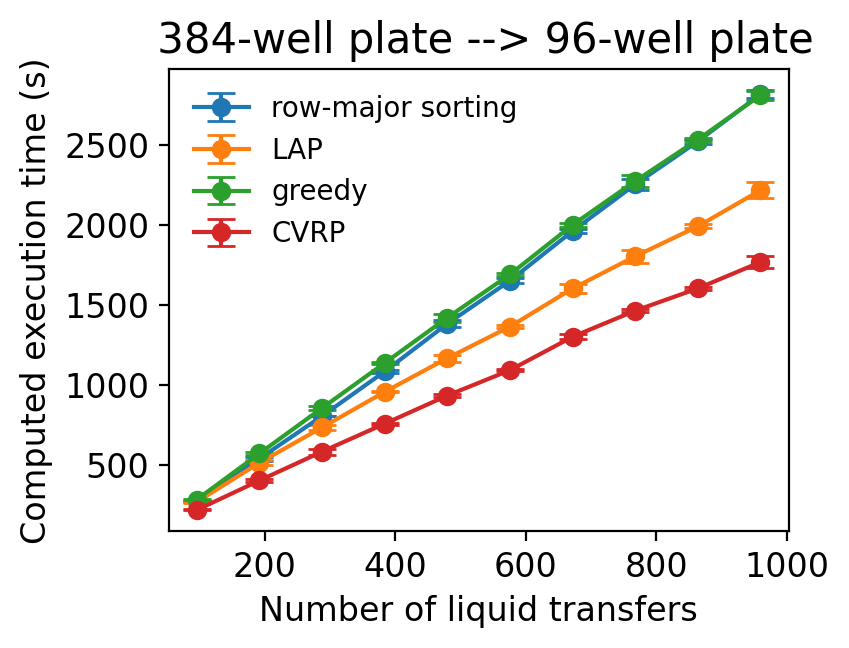

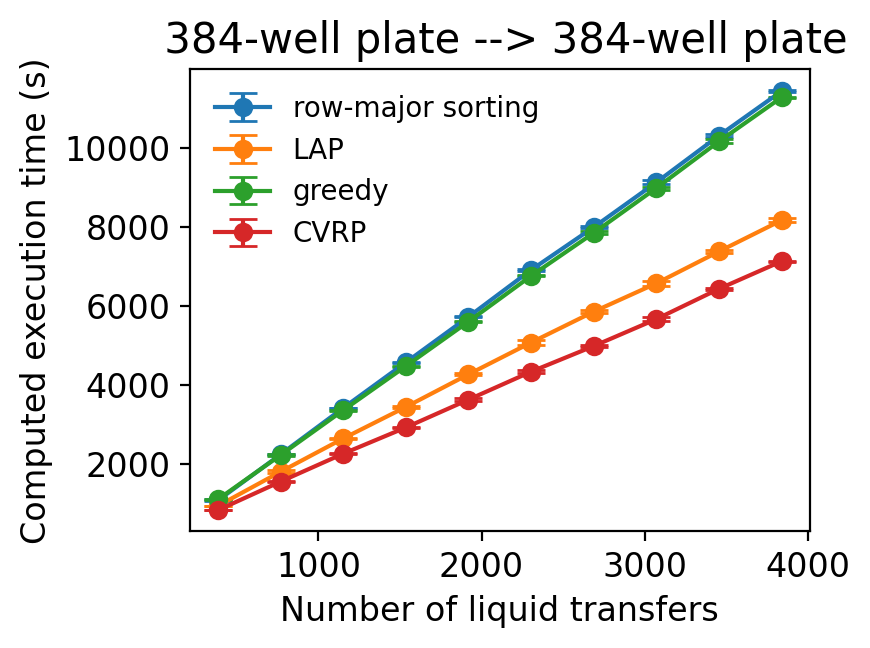

In [5]:
for labware_combination in labware_combinations:
    source = labware_combination[0]
    dest = labware_combination[1]
    df_choosen = df[(df['source_labware'] == source) & (df['dest_labware'] == dest)]
    # compute the mean and std of the unoptimized, rowwise, greedy and VRP
    df_choosen_mean = df_choosen.groupby(['num_samples']).mean().reset_index()
    df_choosen_std = df_choosen.groupby(['num_samples']).std().reset_index()
    # plot the results
    plt.figure(figsize=(4, 3),dpi=200,clear=True)
    plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['unoptimized'], yerr=df_choosen_std['unoptimized'], label='row-major sorting', fmt='o-', capsize=5)
    plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['rowwise'], yerr=df_choosen_std['rowwise'], label='LAP', fmt='o-', capsize=5)
    plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['greedy'], yerr=df_choosen_std['greedy'], label='greedy', fmt='o-', capsize=5)
    plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['VRP'], yerr=df_choosen_std['VRP'], label='CVRP', fmt='o-', capsize=5)
    plt.title(f' {source}-well plate --> {dest}-well plate', fontsize=15)
    plt.xlabel('Number of liquid transfers', fontsize=12)
    plt.ylabel('Computed execution time (s)', fontsize=12)
    # tick labels size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.locator_params(nbins=7)
    plt.legend(frameon=False)
    #plt.tight_layout()
    plt.show()

In [6]:
np.random.seed(0)
df = pd.DataFrame(columns=['source_labware', 'dest_labware', 'num_samples', 'repeat', 'unoptimized','rowwise', 'greedy','VRP'])
for labware_combination in range(1): 

    source_dim = 1536
    dest_dim = 1536
    print(f'source_dim={source_dim}, dest_dim={dest_dim}')
    for r in range(3):
        print('repeat:',r+1)
        stats = []
        for i in range(1, 11, 2):

            num_candidates = dest_dim * i 
            num_candidates = int(num_candidates)
            print(f'num_candidates={num_candidates}')
            a = random_task_generation(source_dim,dest_dim,num_candidates)
            #a[a>0] = 1
            jobs = np.argwhere(a)
            D_S = calculate_D(a.shape[0])
            D_D = calculate_D(a.shape[1])
            S, E, volumes = calculate_S_E(a)
            # calculate distance matrix
            D_prime = calculate_D_prime(D_S, D_D, S, E, volumes, 1, 100, 1, 100)
            # VRP solver
            if num_candidates <7000:
                VRP_distance, VRP_recorder = CVRP_solver(np.round(D_prime * 100).astype(np.int64), solving_time=60)
            else:
                VRP_distance, VRP_recorder = CVRP_solver(np.round(D_prime * 100).astype(np.int64), solving_time=120)
            VRP_distance = VRP_distance / 100
            print(f'VRP_distance: {VRP_distance}')
            # calculate the cost of the non-optimized sequence
            tasks = np.array(range(jobs.shape[0]))
            tasks = tasks+1
            # if tasks.shape[0] %8 != 0, pad with -1
            if tasks.shape[0] %8 != 0:
                tasks = np.pad(tasks, (0, 8-tasks.shape[0]%8), 'constant', constant_values=-1)
            unoptimized_seuqnece = tasks.reshape(-1, 8)
            t = calculate_T(unoptimized_seuqnece)
            d = np.round(D_prime * 100)
            non_optimized_distance = np.trace(np.dot(t.T, d))/100
            # change non_optimized_distance to integer
            non_optimized_distance = int(non_optimized_distance)
            print(f'non_optimized_distance: {non_optimized_distance}')
            
            # calculate the cost of the row-wise optimized sequence
            index_matrix = np.zeros((source_dim,dest_dim))
            for j in range(jobs.shape[0]):
                index_matrix[jobs[j, 0], jobs[j, 1]] = j+1
            row_wise_optimized_sequence = LAP(index_matrix)
            if row_wise_optimized_sequence.shape[0] %8 != 0:
                row_wise_optimized_sequence = np.pad(row_wise_optimized_sequence, (0, 8-row_wise_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
            row_wise_optimized_sequence = row_wise_optimized_sequence.reshape(-1, 8)
            t = calculate_T(row_wise_optimized_sequence)
            row_wise_optimized_distance = np.trace(np.dot(t.T, d))/100
            # change non_optimized_distance to integer
            row_wise_optimized_distance = int(row_wise_optimized_distance)
            print(f'row_wise_optimized_distance: {row_wise_optimized_distance}')

            # calculate the cost of the greedy optimized sequence
            greedy_optimized_sequence = greedy(jobs, d[1:,1:])
            if greedy_optimized_sequence.shape[0] %8 != 0:
                greedy_optimized_sequence = np.pad(greedy_optimized_sequence, (0, 8-greedy_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
            greedy_optimized_sequence = greedy_optimized_sequence.reshape(-1, 8)
            t = calculate_T(greedy_optimized_sequence)
            greedy_optimized_distance = np.trace(np.dot(t.T, d))/100
            print(f'greedy_optimized_distance: {greedy_optimized_distance}')
            # append the results to the df
            stats.append([source_dim, dest_dim, num_candidates, r+1, non_optimized_distance, row_wise_optimized_distance, greedy_optimized_distance, VRP_distance])
        # convert the stats to the dataframe
        stats = pd.DataFrame(stats, columns=['source_labware', 'dest_labware', 'num_samples', 'repeat', 'unoptimized','rowwise', 'greedy','VRP'])
        # append the stats to the df
        df = pd.concat([df, stats], ignore_index=True)
        print(df)


source_dim=1536, dest_dim=1536
repeat: 1
num_candidates=1536
VRP_distance: 3431.38
non_optimized_distance: 4546
row_wise_optimized_distance: 3837
greedy_optimized_distance: 4504.83
num_candidates=4608
VRP_distance: 9371.63
non_optimized_distance: 13834
row_wise_optimized_distance: 10625
greedy_optimized_distance: 13518.36
num_candidates=7680
VRP_distance: 15084.56
non_optimized_distance: 23140
row_wise_optimized_distance: 17165
greedy_optimized_distance: 22591.68
num_candidates=10752
VRP_distance: 20737.79
non_optimized_distance: 32206
row_wise_optimized_distance: 23428
greedy_optimized_distance: 31558.64
num_candidates=13824
VRP_distance: 26034.45
non_optimized_distance: 41501
row_wise_optimized_distance: 29894
greedy_optimized_distance: 40744.14
  source_labware dest_labware num_samples repeat unoptimized rowwise  \
0           1536         1536        1536      1        4546    3837   
1           1536         1536        4608      1       13834   10625   
2           1536         1

/var/folders/rt/qt1716456c913tnjd66ntj8w0000gn/T/ipykernel_40237/2835025608.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, stats], ignore_index=True)


VRP_distance: 3404.87
non_optimized_distance: 4551
row_wise_optimized_distance: 3851
greedy_optimized_distance: 4524.85
num_candidates=4608
VRP_distance: 9383.26
non_optimized_distance: 13843
row_wise_optimized_distance: 10673
greedy_optimized_distance: 13487.88
num_candidates=7680
VRP_distance: 14916.42
non_optimized_distance: 22926
row_wise_optimized_distance: 17130
greedy_optimized_distance: 22448.4
num_candidates=10752
VRP_distance: 20780.27
non_optimized_distance: 32289
row_wise_optimized_distance: 23694
greedy_optimized_distance: 31623.88
num_candidates=13824
VRP_distance: 26108.98
non_optimized_distance: 41491
row_wise_optimized_distance: 30062
greedy_optimized_distance: 40738.74
  source_labware dest_labware num_samples repeat unoptimized rowwise  \
0           1536         1536        1536      1        4546    3837   
1           1536         1536        4608      1       13834   10625   
2           1536         1536        7680      1       23140   17165   
3           1536

In [7]:
df.to_csv('/Users/roywu/Desktop/MIT/Project/pipette_scheduling/results/1536_results.csv', index=False)

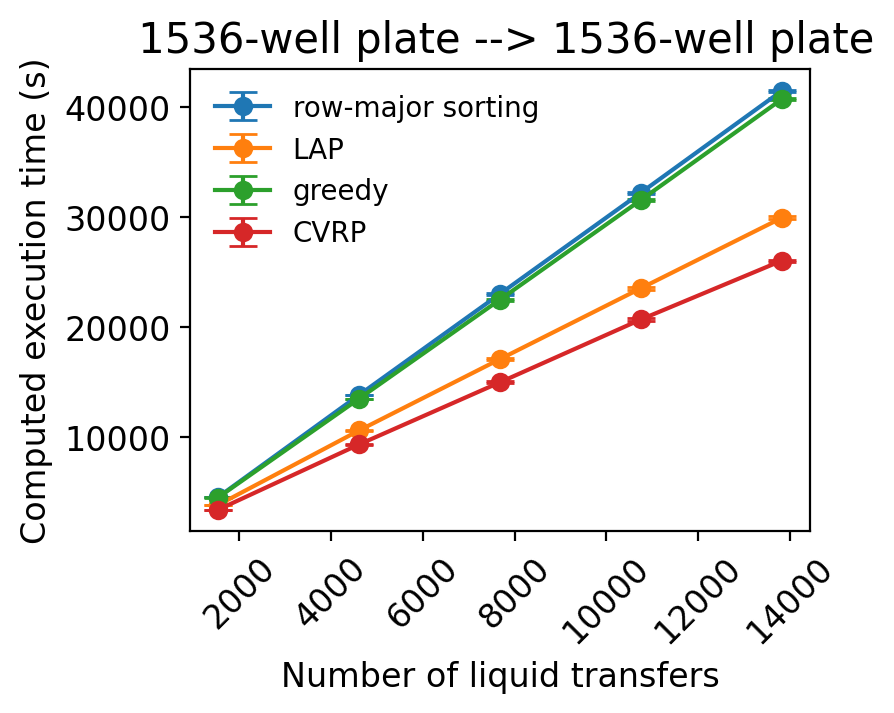

In [8]:
source = 1536
dest = 1536
df_choosen = df[(df['source_labware'] == source) & (df['dest_labware'] == dest)]
# compute the mean and std of the unoptimized, rowwise, greedy and VRP
df_choosen_mean = df_choosen.groupby(['num_samples']).mean().reset_index()
df_choosen_std = df_choosen.groupby(['num_samples']).std().reset_index()
# plot the results
plt.figure(figsize=(4, 3),dpi=200,clear=True)
plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['unoptimized'], yerr=df_choosen_std['unoptimized'], label='row-major sorting', fmt='o-', capsize=5)
plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['rowwise'], yerr=df_choosen_std['rowwise'], label='LAP', fmt='o-', capsize=5)
plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['greedy'], yerr=df_choosen_std['greedy'], label='greedy', fmt='o-', capsize=5)
plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['VRP'], yerr=df_choosen_std['VRP'], label='CVRP', fmt='o-', capsize=5)
plt.title(f' {source}-well plate --> {dest}-well plate', fontsize=15)
plt.xlabel('Number of liquid transfers', fontsize=12)
plt.ylabel('Computed execution time (s)', fontsize=12)
# tick labels size
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.locator_params(nbins=7)
plt.legend(frameon=False)
#plt.tight_layout()
plt.show()